In [1]:
import matplotlib.pyplot as plt
import numpy as np

From the code in subsequest cells I got to know that residual is nothing but error(y-y_hat). Calculating mean squared error in following cell. Just taking square of the error and then taking it's mean.

In [2]:
# Mean squared error from residual
def mse_from_e(residual):
    ########  ACT - 1 ######
    n = residual.shape[0]
    mse = np.mean(residual ** 2)  # Calculating mse.
    return mse

# Mean Squared Error of X.w - y
def mean_squared_error(X, y, w):
    ########  ACT - 2 ######
    y_hat = X @ w
    mse = np.mean((y-y_hat) ** 2)
    return mse


Following cell is generating dataset with noise.

In [3]:
# Generate a sawtooth weight vector
def genu(d, m):
    u = np.arange(d) * (2 * (np.arange(d) % 2) - 1)
    u = m * u / np.sqrt(np.dot(u, u))
    return u

# Generate random data
def genx(n, d):
    X = np.random.randint(0, 2, (n, d))
    X[:, int(d/2)] = 1
    return X

# Generate targets and add noise
def gent(X, u, noise):
    n = X.shape[0]
    y = np.dot(X, u).reshape(n, 1)
    y += noise * np.var(y) * np.random.randn(n, 1)
    return y

# Generate data, weights, and targets
def gimme_data_regres(n, d, noise=0.1):
    u = genu(d, 1.0)
    X = genx(n, d)
    y = gent(X, u, noise)
    mse_gen = mean_squared_error(X, y, u)
    print('Generator Loss={0:8.5f}\n'.format(mse_gen))
    return X, u, y

Following functions help to plot the graphs. "use_notebook" is a check which helps in testing the code. If use_notebook is False then it will print all the graphs when code is run otherwise it will run only code and will not print any graphs which will help to debug the code without any headache.

In [4]:
# Plot loss as a function of epoch
use_notebook = False
def loss_plotter(vlist, fname):
    vr = vlist[0]
    vn = vlist[1]
    if not use_notebook:
        plt.figure(fname)
    plt.plot(range(1, 1+len(vr)), vr,
           range(1, 1+len(vn)), vn,
           linewidth=2, linestyle='-', marker='o')
    plt.legend(('rep', 'nor'))
    plt.grid()
    xt = np.arange(1, 1 + max(len(vr), len(vn)))
    _ = plt.xticks(xt)
    _ = plt.xlabel('Epoch', fontsize=14)
    _ = plt.ylabel(fname, fontsize=14)
    if not use_notebook:
        plt.show(block=False)
    return

# Scatter plot of predicted vs. observed targets
def loss_scatter(X, y, w, fname):
    if not use_notebook:
        plt.figure(fname)
    plt.scatter(y, np.dot(X, w), edgecolors=(0,0,0))
    plt.plot([y.min(), y.max()], [y.min(), y.max()],'k--', lw=4)
    plt.grid()
    plt.xlabel('$y$', fontsize=14)
    plt.ylabel('$\hat{y}$', fontsize=14)
    if not use_notebook:
        plt.show(block=False)

Generating random index for choosing a column from given dataset. If index is replaceable then just calling randint function of numpy will take care of everything. But, in the case of without replaceable we are using the concept of objects in python. Python do consider evertyhing as a object so functions are also objects. We will put the suffled number from 0 to d-1 in a list and assign to attribute "prm" of function. Then with maintaining a pointer head we can easily generate random numbers d times. When we are done for current dataset it will be automatically reset for new dataset.

In [5]:
# sample new index (w/ or w/o replacement)
def sample_new_index(d, replace=1):
    if replace:
        ########  ACT - 3 ######
        index = np.random.randint(d)
    else:
        if 'prm' not in sample_new_index.__dict__:
            sample_new_index.prm = np.random.permutation(d)
            sample_new_index.head = 0
        ########  ACT - 4 ######
        index = sample_new_index.prm[sample_new_index.head] # Getting a random value from permutation.
        sample_new_index.head += 1      # Keeping track which value has been chosen.

        # Deleting prm attribute and setting head to zero if all values has been chosen.
        if sample_new_index.head == d:
            sample_new_index.head = 0
            del sample_new_index.prm
        
    return index


In the following cell there are two functions above one is helper for below one. Calculating delta_wj(a) is just easy, take dot product of "e and xj" and divide it by norm then take negative of it. In the update function, to update wj just add delta to it's current value and for residual add delta multiplied with xj to it's previous value.

In [6]:
# calculate the change to w[j] wrt current margins z
# xjs is the squared norm of the jth column of X, a.k.a. ||xj||^2
def delta_wj(e, xj, xjs):
    ##### ACT - 5  ######
    a = -(np.dot(e.T, xj)/xjs)
    return a

# Return new values for w[j] and residual
def update(wj, e, xj, xjs):
    ##### ACT - 6   ######
    delta = delta_wj(e, xj, xjs)
    wj = wj + delta
    residual = e + delta * xj
    return wj, residual

Initializing w as zero vector of length d since it is a standard practice. Initializing residual negative of the target vector since initially predicted targets are nothing so considering them as 0's. Initializing xjs as the norm of the dataset(X) column-wise.

In [7]:
# Initialize all variables using the zero vector for w
# (Initialize w as the zero vector)
# You should return w, xjs, residual
def initialize(X, y):
    ########  ACT - 7 ######
    n, d = X.shape
    w = np.zeros((d, 1))    # Initializing w as zero vector
    residual = -y           # Initial residual is a negative vector of target values.
    xjs = np.sum(X**2, axis=0)     # Calculating norm of column vectors in matrix X.
    return w, xjs, residual
    

Termination condition is the ratio of difference of last two mse's and last mse. If it is less than eps then terminate otherwise continue.

In [8]:
# Check whether termination condition is met
def mse_check(mse_p, mse_c, eps):
    #####  ACT- 8  #####
    return (mse_p - mse_c) / mse_c  < eps   # Calculating ratio.

In [9]:
# Linear regression using coordinate decent
def linear_regression_cd(X, y, epochs=100, eps=0.001, replace=1):
    w, xjs, residual = initialize(X, y)
    mse_cd = [mse_from_e(residual)]
    n, d = X.shape
    for e in range(d * epochs):
        j = sample_new_index(d, replace)
        xj = X[:, j].reshape(n, 1)
        w[j], residual = update(w[j], residual, xj, xjs[j])
        if (e + 1) % d == 0:
            mse_cd.append(mse_from_e(residual))
            print('Epoch: {0:2d}  MSE: {1:5.3f}'.format(int((e+1)/d), mse_cd[-1]))
            if mse_check(mse_cd[-2], mse_cd[-1], eps): break
    return w, mse_cd

Generator Loss= 0.53787

Epoch:  1  MSE: 0.181
Epoch:  2  MSE: 0.097
Epoch:  3  MSE: 0.082
Epoch:  4  MSE: 0.072
Epoch:  5  MSE: 0.070
Epoch:  6  MSE: 0.068
Epoch:  7  MSE: 0.057
Epoch:  8  MSE: 0.055
Epoch:  9  MSE: 0.055
Epoch: 10  MSE: 0.055
Epoch: 11  MSE: 0.055
Epoch: 12  MSE: 0.055
Epoch: 13  MSE: 0.055
Epoch:  1  MSE: 0.153
Epoch:  2  MSE: 0.113
Epoch:  3  MSE: 0.072
Epoch:  4  MSE: 0.063
Epoch:  5  MSE: 0.056
Epoch:  6  MSE: 0.055
Epoch:  7  MSE: 0.055
Epoch:  8  MSE: 0.055
Epoch:  9  MSE: 0.055
Epoch: 10  MSE: 0.055
Epoch: 11  MSE: 0.055
Epoch: 12  MSE: 0.055


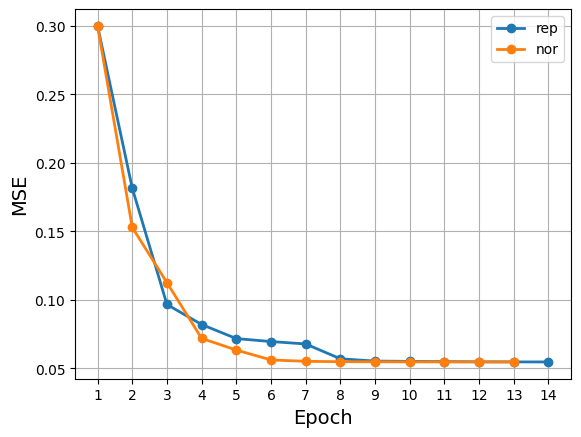

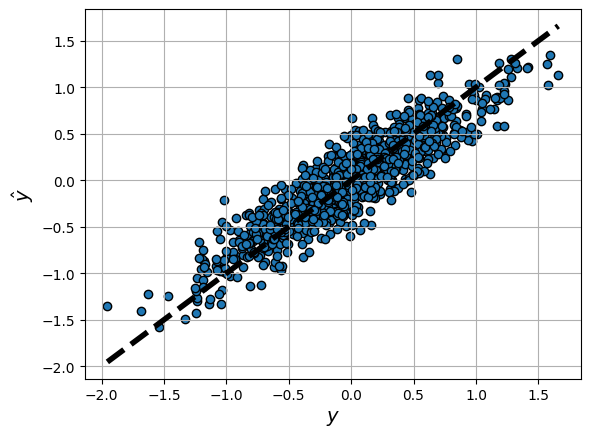

In [10]:
# ---------------- Main for linear regression using Coordinate Descent --------------

np.random.seed(12)
n, d, noise = 1000, 20, 1.0
myeps = 1e-4

[X, u, y] = gimme_data_regres(n, d, noise)

mse_list = []
[wr, mse_r] = linear_regression_cd(X, y, eps=myeps)
mse_list.append(mse_r)
[wn, mse_n] = linear_regression_cd(X, y, eps=myeps, replace=0)
mse_list.append(mse_n)

if not use_notebook:
    plt.close('all')
loss_plotter(mse_list, 'MSE')
loss_scatter(X, y, wn, 'True vs. Predicted Outcome')

# Analysis/Observation
